## ARIMA model forecasting

In [1]:
import dask
import numpy as np
import pandas as pd
import dask.dataframe as dd
import math
from dask.distributed import Client
#Importing plot lib
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
sns.set(rc={'figure.figsize':(20, 10)})
import statsmodels as sm
from statsmodels.tsa.stattools import adfuller
from numpy import log
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima.utils import ndiffs
import pmdarima as pm
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from math import sqrt
import warnings;
warnings.filterwarnings('ignore');
plt.rcParams.update({'figure.figsize':(20,20), 'figure.dpi':200})

In [2]:
data_win = dd.read_csv('data_win.csv').compute()
data_win.head()

,te,pkt,byt,label
0,2016-06-01 00:05:00,9137379,5169739889,0
1,2016-06-01 00:10:00,12126441,8373608719,0
2,2016-06-01 00:15:00,13050846,9565382340,0
3,2016-06-01 00:20:00,11543577,8782554929,0
4,2016-06-01 00:25:00,11745197,8282543104,0


In [3]:
data_normal_traffic_win = dd.read_csv('data_normal_traffic_win.csv').compute()
data_normal_traffic_win.head()

,te,pkt,byt
0,2016-06-01 00:05:00,9137379,5169739889
1,2016-06-01 00:10:00,12126441,8373608719
2,2016-06-01 00:15:00,13050846,9565382340
3,2016-06-01 00:20:00,11543577,8782554929
4,2016-06-01 00:25:00,11745197,8282543104


In [4]:
test_data_normal_traffic_win = dd.read_csv('test_data_normal_traffic_win.csv').compute()
test_data_normal_traffic_win.head()

,te,pkt,byt
0,2016-06-20 00:05:00,4678691,3216020051
1,2016-06-20 00:10:00,10912169,8318748638
2,2016-06-20 00:15:00,9991484,7257315772
3,2016-06-20 00:20:00,11717672,8485465746
4,2016-06-20 00:25:00,10170520,7872342903


In [5]:
test_data_win = dd.read_csv('test_data_win.csv').compute()
test_data_win.head(10)

,te,pkt,byt,label
0,2016-06-20 00:05:00,4678691,3216020051,0
1,2016-06-20 00:10:00,10912169,8318748638,0
2,2016-06-20 00:15:00,9991484,7257315772,0
3,2016-06-20 00:20:00,11717672,8485465746,0
4,2016-06-20 00:25:00,10170520,7872342903,0
5,2016-06-20 00:30:00,10105649,7638145388,0
6,2016-06-20 00:35:00,9823901,7305766930,0
7,2016-06-20 00:40:00,9275407,6909553722,0
8,2016-06-20 00:45:00,9228637,6909369247,0
9,2016-06-20 00:50:00,8767190,6403418333,0


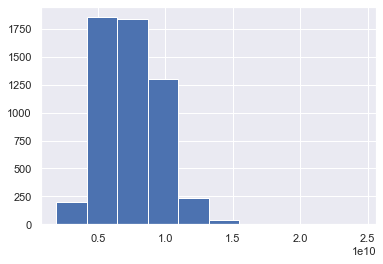

In [6]:
#Checking if data is normal distribution
plt.hist(data_normal_traffic_win.byt)
plt.show()
plt.close()

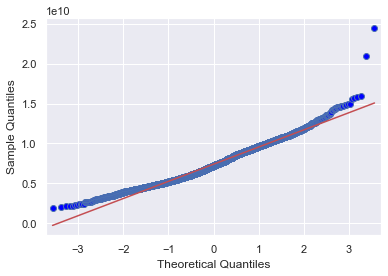

In [7]:
#QQ plot
from statsmodels.graphics.gofplots import qqplot
qqplot(data_normal_traffic_win.byt, line='s')
plt.show()
plt.close()

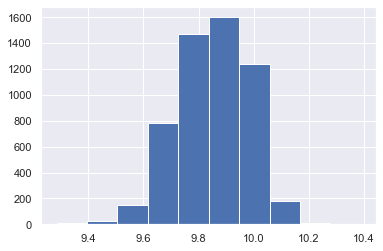

In [8]:
#Plotting the data after log10
plt.hist(np.log10(data_normal_traffic_win.byt))
plt.show()
plt.close()

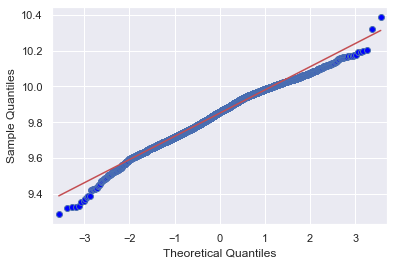

In [9]:
qqplot(np.log10(data_normal_traffic_win.byt), line='s')
plt.show()
plt.close()

### log transformation shows better gaussian distribution. Hence converting data to log10

In [10]:
data_normal_traffic_win_log = data_normal_traffic_win.copy()
data_normal_traffic_win_log['byt'] = np.log10(data_normal_traffic_win_log.byt)

In [11]:
test_data_normal_traffic_win_log = test_data_normal_traffic_win.copy()
test_data_normal_traffic_win_log['byt'] = np.log10(test_data_normal_traffic_win_log.byt)

In [12]:
test_data_win_log = test_data_win.copy()
test_data_win_log['byt'] = np.log10(test_data_win_log.byt)

In [13]:
np.log10(data_normal_traffic_win.byt)

0       9.713469
1       9.922913
2       9.980702
3       9.943621
4       9.918164
          ...   
5468    9.875590
5469    9.902456
5470    9.895093
5471    9.888663
5472    9.615943
Name: byt, Length: 5473, dtype: float64

### Analysing timeseries windowed data

In [14]:
#Checking ADF stats, p-value
result = adfuller(data_normal_traffic_win_log.byt, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'n_lags: {result[1]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}') 

ADF Statistic: -6.080038632384012
n_lags: 1.0977930565680669e-07
p-value: 1.0977930565680669e-07
Critial Values:
   1%, -3.431551098654962
Critial Values:
   5%, -2.8620707653126733
Critial Values:
   10%, -2.567052525371161


### p-values is less than significance level 0.5. Hence differencing is not required and series is already stationary

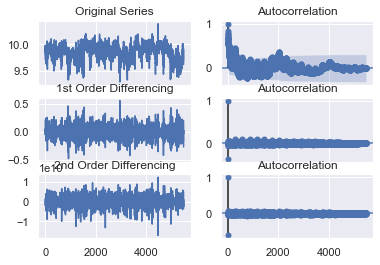

In [15]:
# Original Series and taking byt as value
fig1, axes1 = plt.subplots(3, 2, sharex=True)
axes1[0, 0].plot(data_normal_traffic_win_log.byt); axes1[0, 0].set_title('Original Series')
plot_acf(data_normal_traffic_win_log.byt,  lags=np.arange(len(data_normal_traffic_win_log)) , ax=axes1[0, 1])

# 1st Differencing
axes1[1, 0].plot(data_normal_traffic_win_log.byt.diff()); axes1[1, 0].set_title('1st Order Differencing')
plot_acf(data_normal_traffic_win_log.byt.diff().dropna(), lags=np.arange(len(data_normal_traffic_win_log) -1), ax=axes1[1, 1])

# 2nd Differencing
axes1[2, 0].plot(data_normal_traffic_win.byt.diff().diff()); axes1[2, 0].set_title('2nd Order Differencing')
plot_acf(data_normal_traffic_win_log.byt.diff().diff().dropna(), lags=np.arange(len(data_normal_traffic_win_log) - 2), ax=axes1[2, 1])
plt.show()
plt.close()

### The differencing for this series looks like 1 st order
The 1st differencing graph  looks stationary and auto correlation graph shows promising. Lets us stick to differencing 1 for now

In [16]:
## Adf Test
ndiffs(data_normal_traffic_win_log.byt, test='adf') 

0

In [17]:
# KPSS test
ndiffs(data_normal_traffic_win_log.byt, test='kpss')

1

In [18]:
# PP test:
ndiffs(data_normal_traffic_win_log.byt, test='pp')

0

### Finding order of the AR term
We will use PACF for AR term

In [ ]:
fig, axes = plt.subplots(3, 1, sharex=True)
axes[0].plot(data_normal_traffic_win_log.byt); axes[0].set_title('Original Series')
axes[1].set(ylim=(0,1))
axes[1].set(xlim=(0, 3500))
axes[1].set_title('Original PACF')
plot_pacf(data_normal_traffic_win_log.byt, ax=axes[1], lags=int(len(data_normal_traffic_win)/2 -1))
axes[2].set(ylim=(0,1))
axes[2].set(xlim=(0, 3500))
axes[2].set_title('1st diff PACF')
plot_pacf(data_normal_traffic_win_log.byt.diff().dropna(), ax=axes[2], lags=int(len(data_normal_traffic_win)/2 -1))
plt.show()
plt.close()

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(data_normal_traffic_win_log.byt, model='additive', freq=5)

fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(15, 12)

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(data_normal_traffic_win_log.byt, order=(1,0,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())

In [ ]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [ ]:
# Actual vs Fitted
model_fit.plot_predict(dynamic=False)
plt.show()
plt.close()

In [ ]:
fc, se, conf = model_fit.forecast(len(test_data_normal_traffic_win_log), alpha=0.05)  # 95% conf

In [ ]:
fc_series = pd.Series(fc, index=test_data_normal_traffic_win_log.index)
lower_series = pd.Series(conf[:, 0], index=test_data_normal_traffic_win_log.index)
upper_series = pd.Series(conf[:, 1], index=test_data_normal_traffic_win_log.index)

In [ ]:

plt.plot(data_normal_traffic_win_log.byt, label='training')
plt.plot(test_data_normal_traffic_win_log.byt, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [ ]:
plt.plot(fc_series, label='forecast')

In [ ]:
# In graph we see seasonality daily, and observations are 5 min 1 ie 12/hr, hence freq= (24*12) = 288
auto_model = pm.auto_arima(data_normal_traffic_win_log.byt, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=5, max_q=5, # maximum p and q
                      m=288,   # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=True,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(auto_model.summary())

In [29]:
#auto_model = pm.auto_arima(data_normal_traffic_win_log.byt, trace=True, seasonal=True)

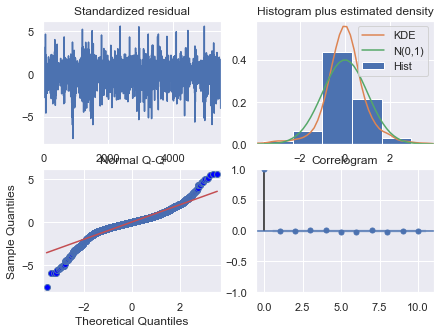

In [30]:
auto_model.plot_diagnostics(figsize=(7,5))
plt.show()

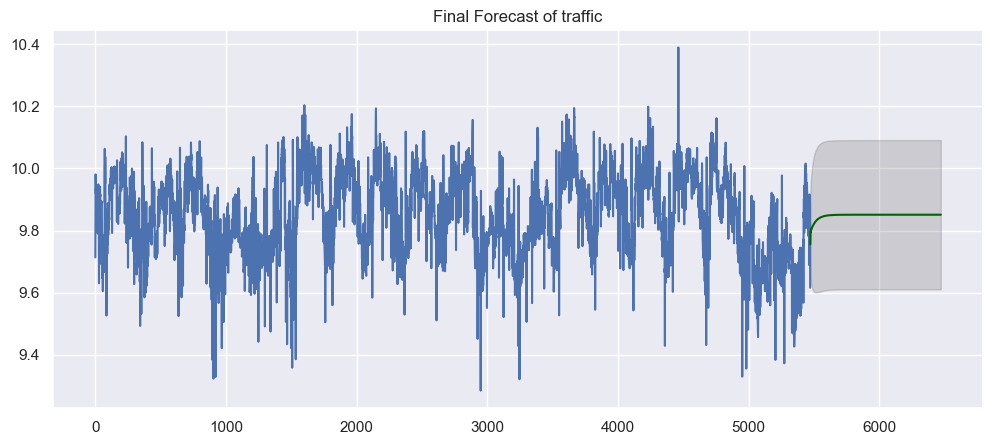

In [31]:
#n_periods = len(test_data_normal_traffic_win)
n_periods = 1000
fc, confint = auto_model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(data_normal_traffic_win_log), len(data_normal_traffic_win_log)+n_periods)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(data_normal_traffic_win_log.byt)
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("Final Forecast of traffic")
plt.show()

In [259]:
# Assumption data in log10 of actual values
def rollingForecats(model, train, test, samples_considered):
    history =  [x for x in train.byt]
    predictions = list()
    #test=pd.Series(test_data_normal_traffic_win.byt)
    test=pd.Series(test.byt)
    
    # walk-forward validation
    #for t in range(len(test_data_normal_traffic_win)):
    for t in range(samples_considered):
        #model = ARIMA(history, order=(4,0,3))
        #model_fit = model.fit()
        model_fit = model.fit(history,enforce_stationarity=False,enforce_invertibility=False)
        #output = model_fit.forecast()
        output = model_fit.predict(n_periods=1)
        yhat = 10**output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
        if t%50 == 0:
            print(str(t)+':predicted=%f, expected=%f' % (yhat, 10**obs))
        # evaluate forecasts
    rmse = sqrt(mean_squared_error(test[:samples_considered], predictions))
    print('Test RMSE: %.3f' % rmse)
    # plot forecasts against actual outcomes
    plt.plot(10**test[:samples_considered], label='Actuals')
    plt.plot(predictions, color='red', label='Predicted')
    plt.show()
    plt.close()
    return predictions


In [391]:
# Assumption data in log10 of actual values
# Check 3 deviation threshold [1.5, 1.75, 2]
def rollingForecats_refined(model, train, test, samples_considered, window, deviation_level=1.5):
    history =  [x for x in train.byt]
    predictions = list()
    anomalies1 = list()
    anomalies2 = list()
    anomalies3 = list()
    error = list()
    #test=pd.Series(test_data_normal_traffic_win.byt)
    test=pd.Series(test.byt)
    
    # walk-forward validation
    #for t in range(len(test_data_normal_traffic_win)):
    for t in range(samples_considered):
        #model = ARIMA(history, order=(4,0,3))
        #model_fit = model.fit()
        model_fit = model.fit(history,enforce_stationarity=False,enforce_invertibility=False)
        #output = model_fit.forecast()
        output = model_fit.predict(n_periods=1)
        yhat = 10**output[0]
        predictions.append(yhat)
        obs = test[t]
        
        # Check for anomaly using error in prediction
        pred_error = obs - output[0]
        error.append(pred_error)
        error_series = pd.Series(error)
        mean_error = error_series.rolling(window=window).mean()[t]
        dev_error = error_series.rolling(window=window).std()[t]
        #1.5
        upper_threshold_error_1 = mean_error + 1.5 * dev_error
        lower_threshold_error_1 = mean_error - 1.5 * dev_error
        #1.75
        upper_threshold_error_2 = mean_error + 1.75 * dev_error
        lower_threshold_error_2 = mean_error - 1.75 * dev_error
        #2
        upper_threshold_error_3 = mean_error + 2 * dev_error
        lower_threshold_error_3 = mean_error - 2 * dev_error

        if math.isnan(mean_error) or math.isnan(dev_error):
            anomalies1.append(0)
            anomalies2.append(0)
            anomalies3.append(0)
        else:
            if pred_error < lower_threshold_error_1 or pred_error > upper_threshold_error_1:
                anomalies1.append(1)
                if deviation_level == 1.5:
                    obs = output
                    # To make sure we have normal traffic prediction
                    #if pred_error < lower_threshold_error_1:
                    #    obs = output - 10**mean_error
                    #else:
                    #    obs = output + 10**mean_error
            else:
                anomalies1.append(0)
                
            if pred_error < lower_threshold_error_2 or pred_error > upper_threshold_error_2:
                anomalies2.append(1)
                if deviation_level == 1.75:
                    obs = output
                    # To make sure we have normal traffic prediction
                    #if pred_error < lower_threshold_error_1:
                    #    obs = output - 10**mean_error
                    #else:
                    #    obs = output + 10**mean_error
            else:
                anomalies2.append(0)
                
            if pred_error < lower_threshold_error_3 or pred_error > upper_threshold_error_3:
                anomalies3.append(1)
                if deviation_level == 2:
                    obs = output
                    # To make sure we have normal traffic prediction
                    #if pred_error < lower_threshold_error_1:
                    #    obs = output - 10**mean_error
                    #else:
                    #    obs = output + 10**mean_error
            else:
                anomalies3.append(0)


        # Append to history
        history.append(obs)
        if t%50 == 0:
            print(str(t)+':predicted=%f, expected=%f, error=%f' % (yhat, 10**obs, pred_error))
        # evaluate forecasts
    rmse = sqrt(mean_squared_error(test[:samples_considered], predictions))
    print('Test RMSE: %.3f' % rmse)
    # plot forecasts against actual outcomes
    plt.plot(10**test[:samples_considered], label='Actuals')
    plt.plot(predictions, color='red', label='Predicted')
    plt.show()
    plt.close()
    return predictions, anomalies1, anomalies2, anomalies3

0:predicted=5693058379.998271, expected=3216020051.000000, error=-0.248027
50:predicted=4679110685.441907, expected=6589375742.000005, error=0.148681
100:predicted=6631133458.939927, expected=7026221412.000010, error=0.025134
150:predicted=9028933264.163691, expected=9346146155.999998, error=0.014996
200:predicted=9773801555.516645, expected=11167173997.000021, error=0.057880
250:predicted=7580718735.127410, expected=9473444435.000008, error=0.096798
300:predicted=7573022127.534321, expected=7862912565.000005, error=0.016314
350:predicted=6241341978.780309, expected=5930342890.999999, error=-0.022198
400:predicted=8181838287.252027, expected=8907115509.999994, error=0.036886
450:predicted=9517753489.588755, expected=9584743063.999990, error=0.003046
Test RMSE: 8145352328.534


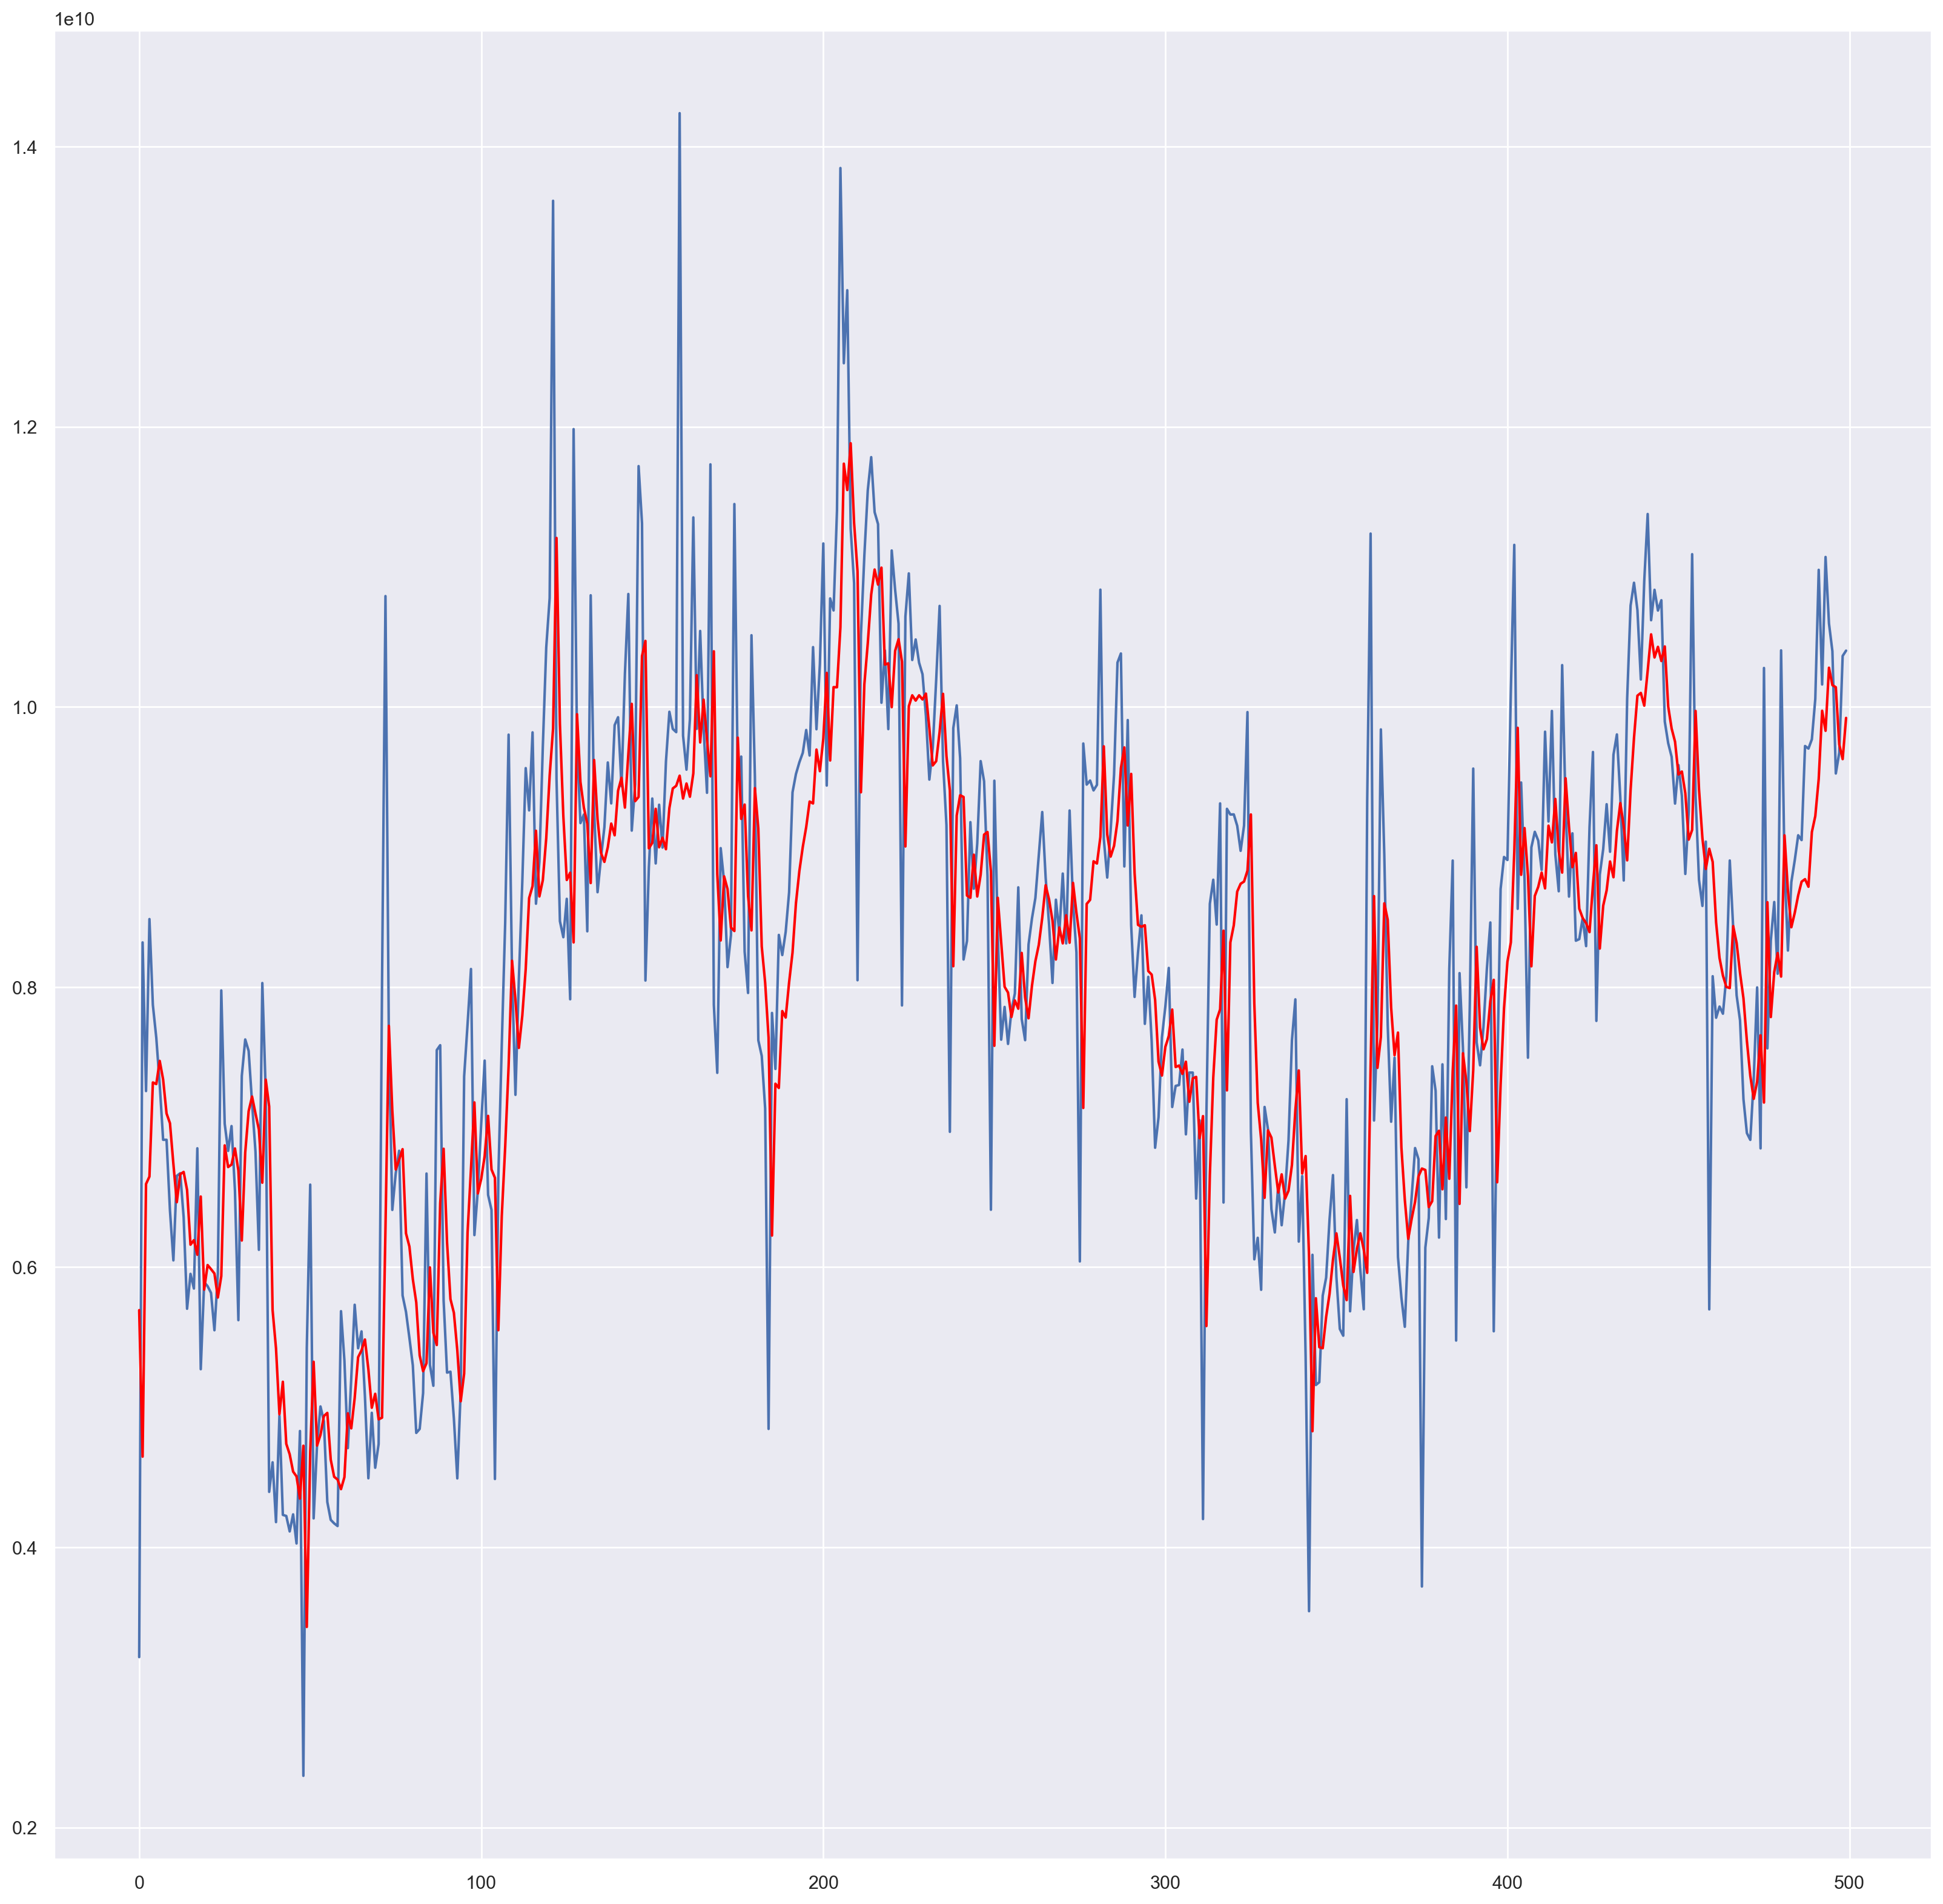

In [430]:
samples = 500
predictions, anomalies1, anomalies2, anomalies3 = rollingForecats_refined(auto_model, data_normal_traffic_win_log, test_data_win_log, samples, 5, 1.75)

In [431]:
def detect_classify_anomalies(df,window):
    df.replace([np.inf, -np.inf], np.NaN, inplace=True)
    df.fillna(0,inplace=True)
    df['error']=df['actuals']-df['predicted']
    df['percentage_change'] = ((df['actuals'] - df['predicted']) / df['actuals']) * 100
    df['meanval'] = df['error'].rolling(window=window).mean()
    df['deviation'] = df['error'].rolling(window=window).std()
    df['-3s'] = df['meanval'] - (2 * df['deviation'])
    df['3s'] = df['meanval'] + (2 * df['deviation'])
    df['-2s'] = df['meanval'] - (1.75 * df['deviation'])
    df['2s'] = df['meanval'] + (1.75 * df['deviation'])
    df['-1s'] = df['meanval'] - (1.5 * df['deviation'])
    df['1s'] = df['meanval'] + (1.5 * df['deviation'])
    cut_list = df[['error', '-3s', '-2s', '-1s', 'meanval', '1s', '2s', '3s']]
    cut_values = cut_list.values
    cut_sort = np.sort(cut_values)
    df['impact'] = [(lambda x: np.where(cut_sort == df['error'][x])[1][0])(x) for x in
    range(len(df['error']))]
    severity = {0: 3, 1: 2, 2: 1, 3: 0, 4: 0, 5: 1, 6: 2, 7: 3}
    region = {0: "NEGATIVE", 1: "NEGATIVE", 2: "NEGATIVE", 3: "NEGATIVE", 4: "POSITIVE", 5: "POSITIVE", 6: "POSITIVE",
    7: "POSITIVE"}
    df['color'] = df['impact'].map(severity)
    df['region'] = df['impact'].map(region)
    df['anomaly_points'] = np.where(df['color'] == 3, df['error'], np.nan)
    df = df.sort_values(by='load_date', ascending=False)
    df.load_date = pd.to_datetime(df['load_date'].astype(str), format="%Y-%m-%d")
    return df

In [432]:
def detect_classify_anomalies_refined(df,window):
    df.replace([np.inf, -np.inf], np.NaN, inplace=True)
    df.fillna(0,inplace=True)
    #df['error']=df['actuals']-df['predicted']
    df['percentage_change'] = ((df['actuals'] - df['predicted']) / df['actuals']) * 100
    df['meanval'] = df['actuals'].rolling(window=window).mean()
    df['deviation'] = df['actuals'].rolling(window=window).std()
    df['-3s'] = df['meanval'] - (2 * df['deviation'])
    df['3s'] = df['meanval'] + (2 * df['deviation'])
    df['-2s'] = df['meanval'] - (1.75 * df['deviation'])
    df['2s'] = df['meanval'] + (1.75 * df['deviation'])
    df['-1s'] = df['meanval'] - (1.5 * df['deviation'])
    df['1s'] = df['meanval'] + (1.5 * df['deviation'])
    cut_list = df[['actuals', '-3s', '-2s', '-1s', 'meanval', '1s', '2s', '3s']]
    cut_values = cut_list.values
    cut_sort = np.sort(cut_values)
    df['impact'] = [(lambda x: np.where(cut_sort == df['actuals'][x])[1][0])(x) for x in
    range(len(df['actuals']))]
    severity = {0: 3, 1: 2, 2: 1, 3: 0, 4: 0, 5: 1, 6: 2, 7: 3}
    region = {0: "NEGATIVE", 1: "NEGATIVE", 2: "NEGATIVE", 3: "NEGATIVE", 4: "POSITIVE", 5: "POSITIVE", 6: "POSITIVE",
    7: "POSITIVE"}
    df['color'] = df['impact'].map(severity)
    df['region'] = df['impact'].map(region)
    df['anomaly_points'] = np.where(df['color'] == 3, df['actuals'], np.nan)
    df = df.sort_values(by='load_date', ascending=False)
    df.load_date = pd.to_datetime(df['load_date'].astype(str), format="%Y-%m-%d")
    return df

In [433]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.plotly as py
import plotly.graph_objs as go
init_notebook_mode(connected=True)
def plot_anomaly(df,metric_name):
    dates = df.load_date
    bool_array = (abs(df['anomaly_points']) > 0)
    #And a subplot of the Actual Values.
    actuals = df["actuals"][-len(bool_array):]
    anomaly_points = bool_array * actuals
    anomaly_points[anomaly_points == 0] = np.nan
    
    color_map= {0: "'rgba(228, 222, 249, 0.65)'", 1: "yellow", 2: "orange", 3: "red"}
    table = go.Table(
            domain=dict(x=[0, 1], y=[0, 0.3]), 
            columnwidth=[1, 2 ],
            #columnorder=[0, 1, 2,],
            header = dict(height = 20,
                        values = [['<b>Date</b>'],['<b>Actual Values </b>'],
                        ['<b>Predicted</b>'], ['<b>% Difference</b>'],['<b>Severity (0-3)</b>']],
                        font = dict(color=['rgb(45, 45, 45)'] * 5, size=14),
                        fill = dict(color='#d562be')),
            cells = dict(values = [df.round(3)[k].tolist() for k in ['load_date', 'actuals', 'predicted',
                    'percentage_change','color']],
            line = dict(color='#506784'),
            align = ['center'] * 5,
            font = dict(color=['rgb(40, 40, 40)'] * 5, size=12),
            #format = [None] + [",.4f"] + [',.4f'],
            #suffix=[None] * 4,
            suffix=[None] + [''] + [''] + ['%'] + [''],
            height = 27,
            #fill = dict(color=['rgb(235, 193, 238)', 'rgba(228, 222, 249, 0.65)']))
            fill=dict(color= # ['rgb(245,245,245)',#unique color for the first column
            [df['color'].map(color_map)],
        )
    ))
    
    #df['ano'] = np.where(df['color']==3, df['error'], np.nan)
    anomalies = go.Scatter(name="Anomaly",x=dates, xaxis='x1', yaxis='y1',
        y=df['anomaly_points'],
        mode='markers',
        marker = dict(color ='red',
                      size = 11,
                      line = dict(
                      color = "red",
                      width = 2)
                     )
    )
    
    upper_bound = go.Scatter(hoverinfo="skip",
                             x=dates,
                             showlegend =False,
                             xaxis='x1',
                             yaxis='y1',
                             y=df['3s'],
                             marker=dict(color="#444"),
                             line=dict(
                                 color=('rgb(23, 96, 167)'),
                                 width=2,
                                 dash='dash'),
                            fillcolor='rgba(68, 68, 68, 0.3)',
                            fill='tonexty'
    )
    
    
    lower_bound = go.Scatter(name='Confidence Interval',
                            x=dates,
                            xaxis='x1',
                            yaxis='y1',
                            y=df['-3s'],
                            marker=dict(color="#444"),
                            line=dict(
                            color=('rgb(23, 96, 167)'),
                            width=2,
                            dash='dash'),
                            fillcolor='rgba(68, 68, 68, 0.3)',
                            fill='tonexty'
    )
    
    
    Actuals = go.Scatter(name= 'Actuals',
                        x= dates,
                        y= df['actuals'],
                        xaxis='x2', yaxis='y2',
                        mode='line',
                        marker=dict(size=12,
                        line=dict(width=1),
                        color="blue")
    )
    
    
    Predicted = go.Scatter(name= 'Predicted',
                            x= dates,
                            y= df['predicted'],
                            xaxis='x2', yaxis='y2',
                            mode='line',
                            marker=dict(size=12,
                            line=dict(width=1),
                            color="orange")
    )
    
    
    # create plot for error...
    Error = go.Scatter(name="Error",
                    x=dates, y=df['error'],
                    xaxis='x1',
                    yaxis='y1',
                    mode='line',
                    marker=dict(size=12,
                    line=dict(width=1),
                    color="red"),
                    text="Error"
    )
    
    
    anomalies_map = go.Scatter(name = "anomaly actual",
                                showlegend=False,
                                x=dates,
                                y=anomaly_points,
                                mode='markers',
                                xaxis='x2',
                                yaxis='y2',
                                marker = dict(color ="red",
                                size = 11,
                                line = dict(
                                color = "red",
                                width = 2))
    )
    
    
    Mvingavrg = go.Scatter(name="Moving Average",
                            x=dates,
                            y=df['meanval'],
                            mode='line',
                            xaxis='x1',
                            yaxis='y1',
                            marker=dict(size=12,
                            line=dict(width=1),
                            color="green"),
                            text="Moving average"
    )
    
    
    axis=dict(
        showline=True,
        zeroline=False,
        showgrid=True,
        mirror=True,
        ticklen=4,
        gridcolor='#ffffff',
        tickfont=dict(size=10)
    )
    
    layout = dict(
            width=2000,
            height=850,
            autosize=False,
            title= metric_name,
            margin = dict(t=75),
            showlegend=True,
            xaxis1=dict(axis, **dict(domain=[0, 1], anchor='y1', showticklabels=True)),
            xaxis2=dict(axis, **dict(domain=[0, 1], anchor='y2', showticklabels=True)),
            yaxis1=dict(axis, **dict(domain=[2 * 0.21 + 0.20 + 0.09, 1], anchor='x1', hoverformat='.2f')),
            yaxis2=dict(axis, **dict(domain=[0.21 + 0.12, 2 * 0.31 + 0.02], anchor='x2', hoverformat='.2f'))
    )
    
    fig = go.Figure(data = [table,anomalies,anomalies_map,
                            upper_bound,lower_bound,Actuals,Predicted,
                            Mvingavrg,Error], 
                    layout = layout
        )
    
    iplot(fig)
    plt.show()


In [434]:
def plot_anomaly_refined(df,metric_name):
    dates = df.load_date
    bool_array = (abs(df['anomaly_points']) > 0)
    #And a subplot of the Actual Values.
    actuals = df["actuals"][-len(bool_array):]
    anomaly_points = bool_array * actuals
    anomaly_points[anomaly_points == 0] = np.nan
    
    color_map= {0: "'rgba(228, 222, 249, 0.65)'", 1: "yellow", 2: "orange", 3: "red"}
    table = go.Table(
            domain=dict(x=[0, 1], y=[0, 0.3]), 
            columnwidth=[1, 2 ],
            #columnorder=[0, 1, 2,],
            header = dict(height = 20,
                        values = [['<b>Date</b>'],['<b>Actual Values </b>'],
                        ['<b>Predicted</b>'], ['<b>% Difference</b>'],['<b>Severity (0-3)</b>']],
                        font = dict(color=['rgb(45, 45, 45)'] * 5, size=14),
                        fill = dict(color='#d562be')),
            cells = dict(values = [df.round(3)[k].tolist() for k in ['load_date', 'actuals', 'predicted',
                    'percentage_change','color']],
            line = dict(color='#506784'),
            align = ['center'] * 5,
            font = dict(color=['rgb(40, 40, 40)'] * 5, size=12),
            #format = [None] + [",.4f"] + [',.4f'],
            #suffix=[None] * 4,
            suffix=[None] + [''] + [''] + ['%'] + [''],
            height = 27,
            #fill = dict(color=['rgb(235, 193, 238)', 'rgba(228, 222, 249, 0.65)']))
            fill=dict(color= # ['rgb(245,245,245)',#unique color for the first column
            [df['color'].map(color_map)],
        )
    ))
    
    #df['ano'] = np.where(df['color']==3, df['error'], np.nan)
    anomalies = go.Scatter(name="Anomaly",x=dates, xaxis='x1', yaxis='y1',
        y=df['anomaly_points'],
        mode='markers',
        marker = dict(color ='red',
                      size = 11,
                      line = dict(
                      color = "red",
                      width = 2)
                     )
    )
    
    upper_bound = go.Scatter(hoverinfo="skip",
                             x=dates,
                             showlegend =False,
                             xaxis='x1',
                             yaxis='y1',
                             y=df['3s'],
                             marker=dict(color="#444"),
                             line=dict(
                                 color=('rgb(23, 96, 167)'),
                                 width=2,
                                 dash='dash'),
                            fillcolor='rgba(68, 68, 68, 0.3)',
                            fill='tonexty'
    )
    
    
    lower_bound = go.Scatter(name='Confidence Interval',
                            x=dates,
                            xaxis='x1',
                            yaxis='y1',
                            y=df['-3s'],
                            marker=dict(color="#444"),
                            line=dict(
                            color=('rgb(23, 96, 167)'),
                            width=2,
                            dash='dash'),
                            fillcolor='rgba(68, 68, 68, 0.3)',
                            fill='tonexty'
    )
    
    
    Actuals = go.Scatter(name= 'Actuals',
                        x= dates,
                        y= df['actuals'],
                        xaxis='x2', yaxis='y2',
                        mode='line',
                        marker=dict(size=12,
                        line=dict(width=1),
                        color="blue")
    )
    
    
    Predicted = go.Scatter(name= 'Predicted',
                            x= dates,
                            y= df['predicted'],
                            xaxis='x2', yaxis='y2',
                            mode='line',
                            marker=dict(size=12,
                            line=dict(width=1),
                            color="orange")
    )
    
    
    # create plot for error...
    #Error = go.Scatter(name="Error",
    #                x=dates, y=df['error'],
    #                xaxis='x1',
    #                yaxis='y1',
    #                mode='line',
    #                marker=dict(size=12,
    #                line=dict(width=1),
    #                color="red"),
    #                text="Error"
    #)
    
    
    anomalies_map = go.Scatter(name = "anomaly actual",
                                showlegend=False,
                                x=dates,
                                y=anomaly_points,
                                mode='markers',
                                xaxis='x2',
                                yaxis='y2',
                                marker = dict(color ="red",
                                size = 11,
                                line = dict(
                                color = "red",
                                width = 2))
    )
    
    
    Mvingavrg = go.Scatter(name="Moving Average",
                            x=dates,
                            y=df['meanval'],
                            mode='line',
                            xaxis='x1',
                            yaxis='y1',
                            marker=dict(size=12,
                            line=dict(width=1),
                            color="green"),
                            text="Moving average"
    )
    
    
    axis=dict(
        showline=True,
        zeroline=False,
        showgrid=True,
        mirror=True,
        ticklen=4,
        gridcolor='#ffffff',
        tickfont=dict(size=10)
    )
    
    layout = dict(
            width=2000,
            height=850,
            autosize=False,
            title= metric_name,
            margin = dict(t=75),
            showlegend=True,
            xaxis1=dict(axis, **dict(domain=[0, 1], anchor='y1', showticklabels=True)),
            xaxis2=dict(axis, **dict(domain=[0, 1], anchor='y2', showticklabels=True)),
            yaxis1=dict(axis, **dict(domain=[2 * 0.21 + 0.20 + 0.09, 1], anchor='x1', hoverformat='.2f')),
            yaxis2=dict(axis, **dict(domain=[0.21 + 0.12, 2 * 0.31 + 0.02], anchor='x2', hoverformat='.2f'))
    )
    
    fig = go.Figure(data = [table,anomalies,anomalies_map,
                            upper_bound,lower_bound,Actuals,Predicted,
                            Mvingavrg], 
                    layout = layout
        )
    
    iplot(fig)
    plt.show()


In [435]:
predicted_df=pd.DataFrame()
predicted_df['load_date']=test_data_normal_traffic_win.reindex().te[:samples]
predicted_df['actuals']=10**test_data_win_log.byt
predicted_df['predicted']=predictions
predicted_df.reset_index(inplace=True)
del predicted_df['index']
predicted_df.head()

,load_date,actuals,predicted
0,2016-06-20 00:05:00,3.216020e+09,5.693058e+09
1,2016-06-20 00:10:00,8.318749e+09,4.647307e+09
2,2016-06-20 00:15:00,7.257316e+09,6.593621e+09
3,2016-06-20 00:20:00,8.485466e+09,6.646933e+09
4,2016-06-20 00:25:00,7.872343e+09,7.318952e+09


In [463]:
classify_df=detect_classify_anomalies(predicted_df,10)
classify_df.reset_index(inplace=True)
del classify_df['index']
plot_anomaly(classify_df,"metric_name")

In [437]:

#classify_df=detect_classify_anomalies(predicted_df,8)
classify_df=detect_classify_anomalies_refined(predicted_df,7)
classify_df.reset_index(inplace=True)
del classify_df['index']
plot_anomaly_refined(classify_df,"metric_name")

In [464]:
y_pred = classify_df['anomaly_points'] = np.where(classify_df['color'] > 2, 1, 0)
y_actual = test_data_win.label[:samples]

In [472]:
result = pd.DataFrame()
result['actual'] = y_actual
result['predicted'] = anomalies1

In [473]:
confusion_matrix(result.actual, result.predicted)

array([[289,  41],
       [151,  19]])

In [474]:
tp, fn, fp, tn = confusion_matrix(result.actual, result.predicted,labels=[1,0]).reshape(-1)
print('Outcome values tp:%d, fn:%d, fp:%d, tn:%d' %(tp, fn, fp, tn))

Outcome values tp:19, fn:151, fp:41, tn:289


In [475]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [476]:
precision_score(result.actual, result.predicted)


0.31666666666666665

In [477]:
recall_score(result.actual, result.predicted)

0.11176470588235295

In [478]:
f1_score(result.actual, result.predicted)

0.16521739130434784

In [479]:
from sklearn.metrics import classification_report
matrix = classification_report(result.actual, result.predicted,labels=[1,0])
print('Classification report : \n',matrix)

Classification report : 
               precision    recall  f1-score   support

           1       0.32      0.11      0.17       170
           0       0.66      0.88      0.75       330

    accuracy                           0.62       500
   macro avg       0.49      0.49      0.46       500
weighted avg       0.54      0.62      0.55       500

